In [1]:
import os, shutil
import subprocess as subp
import numpy as np
import mdtraj
import matplotlib.pyplot as plt
import scipy.signal

In [2]:
# number of simulations per epoch
N = 16
gmx = "gmx"

# input files for grompping
mdp   = "mdrun.mdp"
topol = "topol.top"
ndx   = "index_grompp.ndx"

# sbatch template variables
email= "santeri.e.paajanen@helsinki.fi"
account="project_2004581"

In [3]:
def gromacs_command(cmd, *args, input=None, **kwargs):
    """ Call the gromacs subcommand cmd. Both args and keys of kwargs should be without the leading dash.
        output is redirected to output_<cmd>.txt.
    """
    command = [gmx, cmd]+["-"+a for a in args]
    for k in kwargs:
        command += ["-"+k, kwargs[k]]
    
    with open("output_%s.txt"%cmd, "w") as fout:
        compProc = subp.run(command, stdout=fout, stderr=subp.STDOUT, input=input)
    
    return compProc.returncode

def init_rep(i):
    """ Initializes rep i
    """
    os.makedirs("epoch01/rep%02d"%i)
    
    # If not found, just load the default
    shutil.copyfile("initial/start.gro", "epoch01/rep%02d/start.gro"%i)
    print("Copied initial/start.gro to rep%02d, starting to grompp..."%i)

    # Save original working dir to come back to
    prevdir = os.getcwd()
    try:
        os.chdir("epoch01/rep%02d"%i)

        rc=gromacs_command("grompp", c="start.gro", f="../../"+mdp, n="../../"+ndx,
                           p="../../"+topol, o="mdrun.tpr", maxwarn="1")

        print("Process returned %d"%rc)

    finally:
        # Whatever happens, we go back to the original working dir
        os.chdir(prevdir)

In [4]:
# Make a pdb file for mdtraj

# Save original working dir to come back to
prevdir = os.getcwd()
try:
    os.chdir("initial")

    rc = gromacs_command("trjconv", f="start.gro", s="start.gro", o="start.pdb", input=b"0\n")
    print("Process returned %d"%rc)
finally:
    # Whatever happens, we go back to the original working dir
    os.chdir(prevdir)

Process returned 0


In [5]:
# Initial structures and first epoch
os.makedirs("epoch01", exist_ok=False)

for i in range(1,N+1):
    init_rep(i)

Copied initial/start.gro to rep01, starting to grompp...
Process returned 0
Copied initial/start.gro to rep02, starting to grompp...
Process returned 0
Copied initial/start.gro to rep03, starting to grompp...
Process returned 0
Copied initial/start.gro to rep04, starting to grompp...
Process returned 0
Copied initial/start.gro to rep05, starting to grompp...
Process returned 0
Copied initial/start.gro to rep06, starting to grompp...
Process returned 0
Copied initial/start.gro to rep07, starting to grompp...
Process returned 0
Copied initial/start.gro to rep08, starting to grompp...
Process returned 0
Copied initial/start.gro to rep09, starting to grompp...
Process returned 0
Copied initial/start.gro to rep10, starting to grompp...
Process returned 0
Copied initial/start.gro to rep11, starting to grompp...
Process returned 0
Copied initial/start.gro to rep12, starting to grompp...
Process returned 0
Copied initial/start.gro to rep13, starting to grompp...
Process returned 0
Copied initi

In [4]:
############################## User input ############################
# To save memory we only load this selection
# mdtraj selection string https://www.mdtraj.org/1.9.5/atom_selection.html
select_str = "protein and residue 638 and not (name =~ 'H.*')"

# Minimum and maximum values to sample from between. None to ignore boundary, "start" string to use the
# initial value of the starting structure
minval=0.79
maxval=1.4


def function_val(positions):
    """
      Write here your analysis function. Positions will be
        numpy array of shape (n,m,3) for n frames of m atoms.
        Note that m is the number of atoms in the selection,
        not the whole trajectory.
      The function should return a numpy array of shape (n).
    """
    m = positions.shape[-2]
    # 4 residues match, so we separate them
    m_res = m//4
    # selections for each res
    ind1 = np.array(list(range(m_res)))
    ind2 = m_res+ind1
    ind3 = m_res+ind2
    ind4 = m_res+ind3
    
    # distances between average position of res1 to average position of res3
    dist1 = np.linalg.norm(np.mean(positions[:,ind1,:], axis=-2)-np.mean(positions[:,ind3,:], axis=-2), axis=-1)
    # same for res 2 and 4
    dist2 = np.linalg.norm(np.mean(positions[:,ind2,:], axis=-2)-np.mean(positions[:,ind4,:], axis=-2), axis=-1)
    
    return np.minimum(dist1, dist2)



############################## User input ############################

In [5]:
load_fval = False # set to True to recalculate analysis even if fval.npy is present
epoch_dir = "" # set if current dir is not the dir with the epoch-directories (and initial-dir)

def load_data(struct, sel, epoch):
    fval = []
    for i in range(1,N+1):
        d = epoch_dir+"epoch%02d/rep%02d/"%(epoch, i)
        if(not load_fval):
            try:
                fval.append(np.load(d+"fval.npy"))
                print("Loaded fval from %sfval.npy"%d)
                continue
            except FileNotFoundError:
                print("Could not open %s"%(d+"fval.npy"))
                
        print("Loading trajectory %s"%(d+"mdrun.xtc"))
        traj = mdtraj.load(d+"mdrun.xtc", top=struct,atom_indices=sel)
        print("Calculating fval")
        fval.append(function_val(traj.xyz))
        print("Saving fval")
        np.save(d+"fval.npy", fval[-1])
    
    reps = [np.full(f.shape,i+1) for i,f in enumerate(fval)]
    frms = [np.arange(len(f)) for f in fval]
    
    return np.concatenate(reps), np.concatenate(fval), np.concatenate(frms)

In [6]:
print("Loading structure and making selection")
struct = mdtraj.load(epoch_dir+"initial/start.pdb")
sel = struct.topology.select(select_str)

startval = function_val(struct.xyz[:,sel,:])

# Min and maxvals
if(minval=="start"):
    minval=startval
elif(minval is None):
    minval=-np.inf

if(maxval=="start"):
    maxval=startval
elif(minval is None):
    maxval=np.inf


print("Selected %d atoms"%len(sel))

Loading structure and making selection
Selected 28 atoms


In [11]:
epochs = 3
fval = []
reps = []
frms = []
for i in range(1,epochs+1):
    r,f,fr = load_data(struct, sel, i)
    reps.append(r)
    fval.append(f)
    frms.append(fr)

    
epcs = [np.full(f.shape,i+1) for i,f in enumerate(fval)]

reps = np.concatenate(reps)
fval = np.concatenate(fval)
epcs = np.concatenate(epcs)
frms = np.concatenate(frms)

Loaded fval from epoch01/rep01/fval.npy
Loaded fval from epoch01/rep02/fval.npy
Loaded fval from epoch01/rep03/fval.npy
Loaded fval from epoch01/rep04/fval.npy
Loaded fval from epoch01/rep05/fval.npy
Loaded fval from epoch01/rep06/fval.npy
Loaded fval from epoch01/rep07/fval.npy
Loaded fval from epoch01/rep08/fval.npy
Loaded fval from epoch01/rep09/fval.npy
Loaded fval from epoch01/rep10/fval.npy
Loaded fval from epoch01/rep11/fval.npy
Loaded fval from epoch01/rep12/fval.npy
Loaded fval from epoch01/rep13/fval.npy
Loaded fval from epoch01/rep14/fval.npy
Loaded fval from epoch01/rep15/fval.npy
Loaded fval from epoch01/rep16/fval.npy
Loaded fval from epoch02/rep01/fval.npy
Loaded fval from epoch02/rep02/fval.npy
Loaded fval from epoch02/rep03/fval.npy
Loaded fval from epoch02/rep04/fval.npy
Loaded fval from epoch02/rep05/fval.npy
Loaded fval from epoch02/rep06/fval.npy
Loaded fval from epoch02/rep07/fval.npy
Loaded fval from epoch02/rep08/fval.npy
Loaded fval from epoch02/rep09/fval.npy


31984
1.4 0.79 31109 311 0.008155111074447632


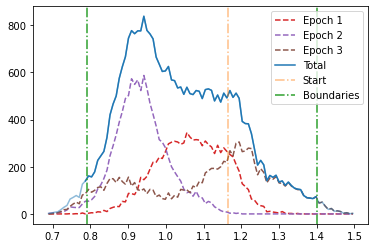

In [12]:
print(len(fval))
_largest_val = np.max(fval)
_lowest_val  = np.min(fval)
_binmax = min(_largest_val, maxval)
_binmin = max(_lowest_val,  minval)
_maxbins = np.sum((fval>minval)*(fval<maxval))//100
_binsize = (_largest_val-_lowest_val)/min(_maxbins,100)
print(_binmax,_binmin, np.sum((fval>minval)*(fval<maxval)),_maxbins,_binsize)
bin_edges = np.arange(_lowest_val,_largest_val+_binsize , _binsize)
hist, bin_edges = np.histogram(fval, bins=bin_edges)
bin_centers = (bin_edges[:-1]+bin_edges[1:])/2
# higher edge larger than minval AND lower edge lower than maxval
mask = (bin_edges[1:]>minval)*(bin_edges[:-1]<maxval)

for i in range(1,epochs+1):
    _ep_hist, _ = np.histogram(fval[epcs==i], bins=bin_edges)
    plt.plot(bin_centers, _ep_hist, "--", color="C%d"%(i+2), label="Epoch %d"%i)


plt.plot(bin_centers, hist, color="C0", alpha=0.5)
plt.plot(bin_centers[mask], hist[mask], color="C0", label="Total")
plt.axvline(startval, linestyle="-.", color="C1", label="Start", alpha=0.5)
plt.axvline(minval, linestyle="-.", color="C2", label="Boundaries")
plt.axvline(maxval, linestyle="-.", color="C2")
plt.legend()
plt.show()


In [23]:
from math import floor, ceil

def rolling_mean(data, window=10, center = True, fill=np.nan):
    if(center):
        start_offset = floor(window/2)
        end_offset   = -ceil(window/2)+1
        if(end_offset==0): end_offset=None
    else:
        start_offset = window-1
        end_offset   = None

    window-=1
    if(window==0): window=None

    cumsum = np.nancumsum(data, axis=0, dtype=float)
    mean   = np.full_like(cumsum, fill)
    mean[start_offset:end_offset] = (cumsum[window:]-cumsum[:-window])/window

    return mean


[] {'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)}
[18] {'prominences': array([639.11111111]), 'left_bases': array([0]), 'right_bases': array([75]), 'widths': array([40.5707872]), 'width_heights': array([453.66666667]), 'left_ips': array([8.99316629]), 'right_ips': array([49.56395349])}
[87, 12] [7.67971014 6.32028986]
[87, 12] [7.67971014 6.32028986]
16 (array([12, 87]), array([7, 9]))


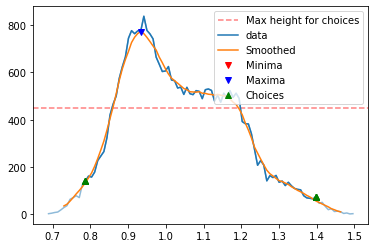

In [20]:
_smoothed = rolling_mean(-hist)
_nanmask = np.isfinite(_smoothed)*mask
_peaks,_que = scipy.signal.find_peaks(_smoothed[_nanmask], width=10, distance=10)
_peaks2,_que2 = scipy.signal.find_peaks(-_smoothed[_nanmask], width=10, distance=10)
print(_peaks, _que)
print(_peaks2, _que2)


_maxh = np.max(hist[mask])
_minh = np.min(hist[mask])
# If not ends have sampled been, make sure min height set to zero is
if(_largest_val<maxval or _lowest_val>minval):
    _minh=0

_crith = (_maxh-_minh)/2+_minh

choices = []
# convert from masked indices to unmasked
_indexes = np.arange(len(hist))[_nanmask]
for p in _peaks:
    if(hist[_nanmask][p]<_crith):
        choices.append(_indexes[p])

_zero_mask = mask*(hist!=0)
_indexes = np.arange(len(hist))[_zero_mask]

# TODO: refactor below
#Handle not peaks-edge case
if(_peaks.size==0):
    if(hist[mask][-1]<_crith):
        choices.append(_indexes[-1])
    if(hist[mask][0]<_crith):
        choices.append(_indexes[0])
else:
    # Check if first/last extrema is a maxima -> also include the far end(s)
    if(_peaks2.size>0 and _peaks[-1]<_peaks2[-1] and hist[mask][-1]<_crith):
        choices.append(_indexes[-1])
    if(_peaks2.size>0 and _peaks[0]>_peaks2[0] and hist[mask][0]<_crith):
        choices.append(_indexes[0])

_weights = [(_crith-hist[c]) for c in choices]
_weights /= np.sum(_weights)
print(choices,(_weights*(N-len(choices))))
_srt_ind = np.argsort(-_weights)
print([choices[i] for i in _srt_ind],(_weights[_srt_ind]*(N-len(choices))))

# Each point has been added once
_len_choice = len(choices)
# Add more depending on weight. Multiplication is floored, so between 0 and _len_choice-1 too few are added
for i in _srt_ind:
    for j in range(floor(_weights[i]*(N-_len_choice))):
        choices.append(choices[i])

# Fill the rest in sorted order
for i in range(N-len(choices)):
    choices.append(choices[_srt_ind[i]])


print(len(choices), np.unique(choices, return_counts=True))

plt.axhline(_crith, linestyle="--", c="r", alpha=0.5, label="Max height for choices")
plt.plot(bin_centers, hist, color="C0", alpha=0.5)
plt.plot(bin_centers[mask], hist[mask], color="C0", label="data")
plt.plot(bin_centers, -_smoothed, color="C1", label="Smoothed")
plt.plot(bin_centers[_nanmask][_peaks], -_smoothed[_nanmask][_peaks], "rv", label="Minima")
plt.plot(bin_centers[_nanmask][_peaks2], -_smoothed[_nanmask][_peaks2], "bv", label="Maxima")
plt.plot(bin_centers[choices], hist[choices], "g^", label="Choices")
plt.legend()
plt.show()


chosen_bins=choices

In [21]:
def choose_frames(chosen_bins):
    global bin_edges, fval, epcs, reps, frms
    _rng = np.random.default_rng()
    # lists for value, rpoch, rep and frame
    v,e,r,f=[],[],[],[]
    for bi in chosen_bins:
        vals_in_bin = (fval >= bin_edges[bi])*(fval < bin_edges[bi+1])
        ndx = _rng.choice(np.sum(vals_in_bin))
        
        v.append(fval[vals_in_bin][ndx])
        e.append(epcs[vals_in_bin][ndx])
        r.append(reps[vals_in_bin][ndx])
        f.append(frms[vals_in_bin][ndx])
    
    return np.array(v), np.array(e), np.array(r), np.array(f)


def next_rep(i,newepoch,oldepoch,rep,frm, val):
    """ Initializes rep i of newepoch, taking the frame frm from rep of oldepoch
    """
    global struct
    os.makedirs("epoch%02d/rep%02d"%(newepoch, i))
    
    print("Reading frame %d of epoch %d, rep %d"%(frm, oldepoch, rep))
    init_struct = mdtraj.load_frame("epoch%02d/rep%02d/mdrun.xtc"%(oldepoch, rep), frm, top=struct)
    
    init_struct.save_gro("epoch%02d/rep%02d/start.gro"%(newepoch, i))
    print("Wrote structure to epoch%02d/rep%02d/start.gro, starting to grompp..."%(newepoch, i))
    
    # Make a note of the origin
    with open("epoch%02d/rep%02d/origin.txt"%(newepoch, i), "w") as f:
        f.write("# Origin of this trajectory:\n")
        f.write("# epoch rep frame val\n")
        f.write("%d %d %d %f\n"%(oldepoch,rep,frm, val))

    # Save original working dir to come back to
    prevdir = os.getcwd()
    try:
        os.chdir("epoch%02d/rep%02d"%(newepoch, i))
        
        # The pdb structure seems to change the atom names, so maxwarn is 2
        rc=gromacs_command("grompp", c="start.gro", f="../../"+mdp, n="../../"+ndx,
                           p="../../"+topol, o="mdrun.tpr", maxwarn="2")

        print("Process returned %d"%rc)

    finally:
        # Whatever happens, we go back to the original working dir
        os.chdir(prevdir)
        
def start_epoch(nextepoch):
    global email, account
    v, e, r, f = choose_frames(chosen_bins)
    print(v, e, r, f)
    
    os.makedirs("epoch%02d"%(nextepoch))
        
    # copy sbatch template
    with open("templates/sbatch_launch.sh") as fin:
        with open("epoch%02d/sbatch_launch.sh"%nextepoch, "w") as fout:
            fout.write(fin.read().format(i=nextepoch, account=account, email=email))

    for i, (val, epoch, rep, frm) in enumerate(zip(v,e,r,f)):
        next_rep(i+1, nextepoch, epoch, rep, frm, val)

In [22]:
nextepoch = epochs+1
print(nextepoch)
start_epoch(nextepoch)

4
[1.3944988  0.7867873  1.3971231  1.3966019  1.3987349  1.3995557
 1.3966019  1.4018303  1.3952476  0.7887113  0.7873369  0.78940773
 0.78310627 0.785466   0.78635615 1.3966019 ] [3 3 3 3 3 3 3 3 3 3 2 2 2 2 3 3] [ 4 12  7  4  1  4  4  1  4  6  8  7  9 11  6  4] [405  19 260 589 512 125 589 302 527 473 643 230 600 378   0 589]
Reading frame 405 of epoch 3, rep 4
Wrote structure to epoch04/rep01/start.gro, starting to grompp...
Process returned 0
Reading frame 19 of epoch 3, rep 12
Wrote structure to epoch04/rep02/start.gro, starting to grompp...
Process returned 0
Reading frame 260 of epoch 3, rep 7
Wrote structure to epoch04/rep03/start.gro, starting to grompp...
Process returned 0
Reading frame 589 of epoch 3, rep 4
Wrote structure to epoch04/rep04/start.gro, starting to grompp...
Process returned 0
Reading frame 512 of epoch 3, rep 1
Wrote structure to epoch04/rep05/start.gro, starting to grompp...
Process returned 0
Reading frame 125 of epoch 3, rep 4
Wrote structure to epoch04/r